# Code and visualization for the challenge

In [1]:
#import lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


In [2]:
training_v2 = pd.read_csv("Data/training_v2.csv")
test = pd.read_csv("Data/unlabeled.csv")
y = training_v2['hospital_death']
X = training_v2
X = training_v2.drop('hospital_death',axis = 1)

In [29]:
descrip_dict = pd.read_csv("Data/WiDS Datathon 2020 Dictionary.csv",index_col = ['Variable Name'])

In [21]:
descrip_dict

,Category,Unit of Measure,Data Type,Description,Example
Variable Name,,,,,
encounter_id,identifier,None,integer,Unique identifier associated with a patient un...,None
hospital_id,identifier,None,integer,Unique identifier associated with a hospital,None
patient_id,identifier,None,integer,Unique identifier associated with a patient,None
hospital_death,demographic,None,binary,Whether the patient died during this hospitali...,0
age,demographic,Years,numeric,The age of the patient on unit admission,None
...,...,...,...,...,...
lymphoma,APACHE comorbidity,None,binary,Whether the patient has been diagnosed with no...,1
solid_tumor_with_metastasis,APACHE comorbidity,None,binary,Whether the patient has been diagnosed with an...,1
apache_3j_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE III,Cardiovascular


### Missing data ###
Tina
Reference:
1. [A New Insight Into Missing Data in Intensive Care Unit Patient Profiles: Observational Study
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6329436/)
    - Using this, we convert variables with the most missing data to another type of indicator called missingness. 0 if missing var 
 
Summary of missing data

Select and fill in important variables that miss a lot of data

In [22]:
#import chart_studio.plotly as py
import missingno as msno 
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [23]:
import plotly.tools as tls 
from plotly.graph_objs import * 

In [8]:
total_patient_data = X.index.nunique()
high_miss_var = []
miss_perct = []
threshold = .50 # variables that have missing 60% 

#X.isnull().sum()

for var in X.columns:
    count = 0 
    for value in X[var].values:
        if pd.isnull(value):    
            count = count + 1     
    miss_rate = (count/total_patient_data)
    if miss_rate >= threshold:
        high_miss_var.append(var)
        miss_perct.append(miss_rate)
missing_stat = pd.DataFrame(miss_perct, columns = ['miss_rate'], index = high_miss_var)


Variables that have high percentages of missing values are illustrated below

In [25]:
fig = px.bar(missing_stat, x=missing_stat.index, y='miss_rate')
fig.show()

In [9]:
missing_stat.miss_rate

albumin_apache          0.592926
bilirubin_apache        0.633869
fio2_apache             0.772715
paco2_apache            0.772715
paco2_for_ph_apache     0.772715
                          ...   
h1_arterial_ph_min      0.833295
h1_arterial_po2_max     0.828072
h1_arterial_po2_min     0.828072
h1_pao2fio2ratio_max    0.874413
h1_pao2fio2ratio_min    0.874413
Name: miss_rate, Length: 74, dtype: float64

In [10]:
#auxiliary matrix (containing the missingness indicators: 0-present, 1-absent)
aux_mask= pd.isnull(X)
augmented_X = X
for m_var in list(missing_stat.index):
    augmented_X[m_var] = aux_mask[m_var]
augmented_X

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,25.0,31.950000,0,Caucasian,F,172.7,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,75.0,23.060250,0,Caucasian,M,177.8,Acute Care/Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,56.0,47.179671,0,Caucasian,F,183.0,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,48.0,27.236914,0,Caucasian,M,170.2,Emergency Department,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,NaN,23.297481,0,Caucasian,F,154.9,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [4]:
augmented_X.to_csv("Data/Augmented_untrained_data.csv")

### Data imputation
Jenny

For features that miss not a lot of data, try interpolation or matrix factorization(do it separately for train and test set)

convert all categorial variables into dummy variables.
For example, under body systems, there are 9 categories: "cardiovascular",
"respiratory", "Metabolic" etc
will insert 9 columns, each column containing 0 or 1

- should not be a string: bmi, apache_2_diagnosis, apache_3j_diagnosis,
- categorical variables: ethnicity, gender, hospital_admit_source, icu_admit_source, icu_admit_type, icu_stay_type, icu_type, readmission_status, apache_3j_bodysystem, apache_2_bodysystem

In [1]:
categorial_variables = ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_admit_type', 'icu_stay_type', 'icu_type', 'readmission_status', 'apache_3j_bodysystem', 'apache_2_bodysystem']

In [ ]:
# some variables should remain 0
# some variables are filled in with mean/median/ frequent etc

In [8]:
from sklearn.impute import SimpleImputer
X_for_imputation = X.copy()

Simple_mean = SimpleImputer(missing_values = np.nan, strategy = "mean")
# Simple_median = SimpleImputer(missing_values = np.nan, strategy = "median")
# Simple_frequent = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
# Simple_constant = SimpleImputer(missing_values = np.nan, strategy = "constant")
X_mean = X_for_imputation.copy()
Simple_mean.fit(X_mean)
# print(Simple_mean.transform(X_mean))

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
# iterative imputation, package is experimental
# I ran this on my laptop for 20 minutes and it gave me this error:
# [IterativeImputer] Early stopping criterion not reached

# require this experimental feature
from sklearn.experimental import enable_iterative_imputer # noqa
from sklearn.impute import IterativeImputer

X_for_imputation = X.copy()

# iterative imputer only works with numbers, not categories
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
iterative_x = X_for_imputation.selecte_dtypes(include=numerics)
iterative = IterativeImputer()
iterative.fit(iterative_x)

In [ ]:
# nearest neighbor imputation

import numpy as np
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer

X_for_imputation = X.copy()
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(X_for_imputation)
mask_missing_values_only

nn_imputer = KNNImputer(n_neighbors = 2, weights = "uniform")
nn_imputer = KNNImputer()
imputer.fit_transform(X_for_imputation)

In [ ]:
# matrix factorization imputation

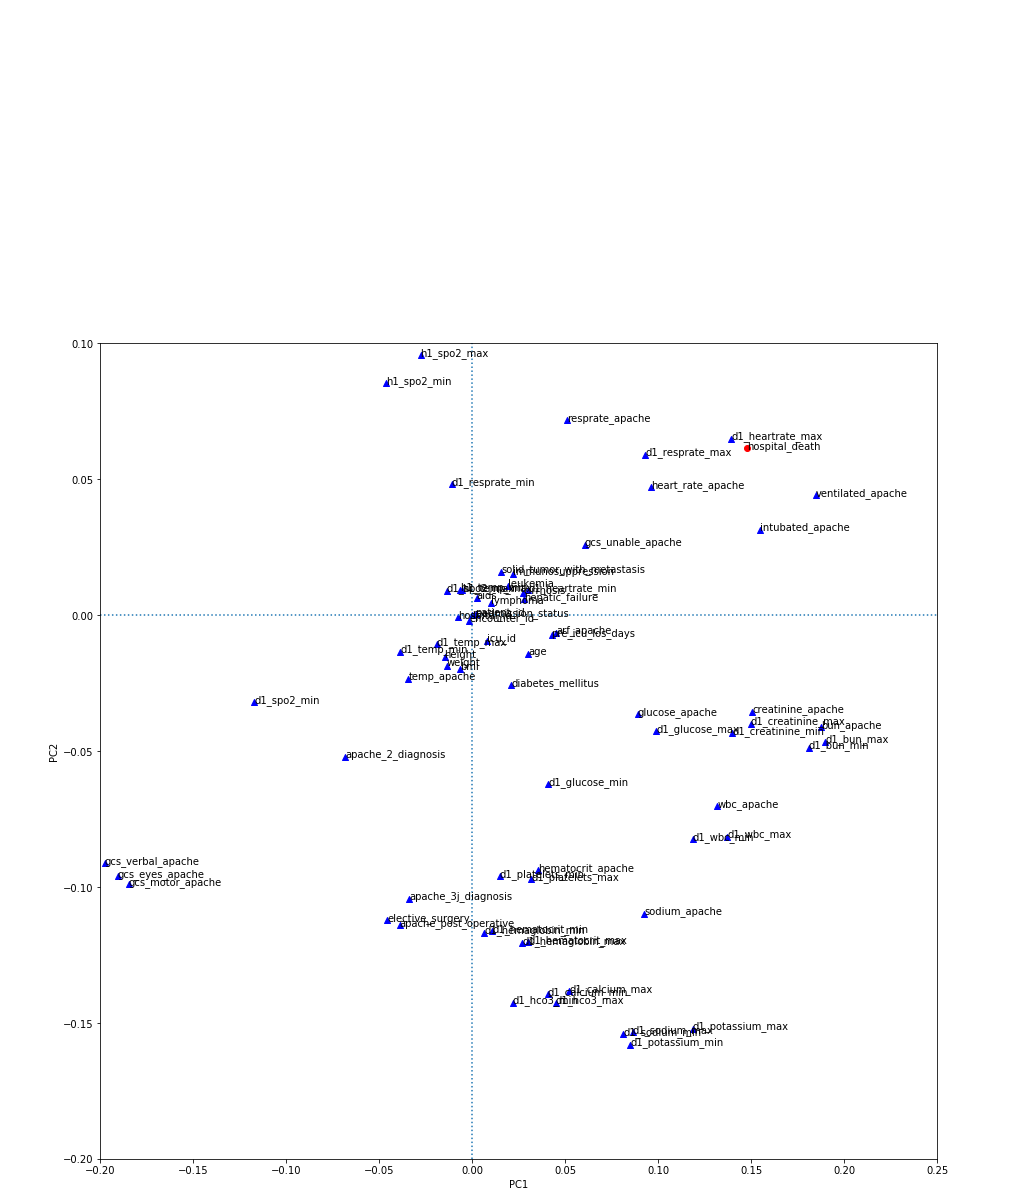

In [34]:
# PCA to identify important components, for PLS-DA model later

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale

true_y = y.copy()
input_training = augmented_X.copy()

# remove non-numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

input_training = input_training.select_dtypes(include=numerics).fillna(0) 
column_names = list(input_training.columns)
input_training = input_training.to_numpy()# (91713, 119)

PLSRmodel = PLSRegression(n_components=2)
PLSRmodel.fit_transform(input_training, true_y);

xloadscores, yloadscores = PLSRmodel.x_loadings_, PLSRmodel.y_loadings_
plt.figure(figsize=(15,15))
plt.xlim(-0.2, 0.25)
plt.ylim(-0.2, 0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(xloadscores[:, 0], xloadscores[:, 1], c='b', marker='^')
plt.scatter(yloadscores[:, 0], yloadscores[:, 1], c='r', marker='o')
plt.axhline(0, linestyle = ":")
plt.axvline(0, linestyle = ":")
plt.annotate('hospital_death', (yloadscores[:, 0], yloadscores[:, 1]))
for i, label in enumerate(column_names):
    plt.annotate(label, (xloadscores[i, 0], xloadscores[i, 1]));

In [108]:
# PLS-DA on training set

# first need to create dummy variable
og_outcome = y.copy()  # 0 = no death, 1 = death
invert_outcome = np.logical_not(og_outcome).astype(int) # 0 = death, 1 = no death
dummy=np.array([og_outcome,invert_outcome]).T

# input training set can't have categorical variables, so 
# remove non-numeric columns
input_numerical_only = augmented_X.copy()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
input_numerical_only = input_numerical_only.select_dtypes(include=numerics).fillna(0)
PLS_input_columns = input_numerical_only.columns
input_numerical_only = input_numerical_only.to_numpy()

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

pls_da=PLSRegression(n_components = 15)
pls_da.fit(X=input_numerical_only, Y=dummy)
Rsquared = r2_score(dummy, pls_da_pred)
print("model fitness (R^2) is ", Rsquared)
pls_da_pred = pls_da.predict(input_numerical_only)
# pls_da_pred contains 2 columns, 
# first is probability of having 0 no death
# second is probability of having 1 death
# plt.scatter(true_y, pls_da_pred[:,0])

model fitness (R^2) is  0.20756612145598569


In [109]:
# PLS-DA on training set

# first need to create dummy variable
og_outcome = y.copy()  # 0 = no death, 1 = death
invert_outcome = np.logical_not(og_outcome).astype(int) # 0 = death, 1 = no death
dummy=np.array([og_outcome,invert_outcome]).T

# input training set can't have categorical variables, so 
# remove non-numeric columns
input_numerical_only = augmented_X.copy()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
input_numerical_only = input_numerical_only.select_dtypes(include=numerics).fillna(0)
PLS_input_columns = input_numerical_only.columns
input_numerical_only = input_numerical_only.to_numpy()

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

pls_da=PLSRegression(n_components = 15)
pls_da.fit(X=input_numerical_only, Y=dummy)
Rsquared = r2_score(dummy, pls_da_pred)
print("model fitness (R^2) is ", Rsquared)
pls_da_pred = pls_da.predict(input_numerical_only)
# pls_da_pred contains 2 columns, 
# first is probability of having 0 no death
# second is probability of having 1 death
# plt.scatter(true_y, pls_da_pred[:,0])

model fitness (R^2) is  0.20756612145598569


In [111]:
from prettytable import PrettyTable

def truth_table(real, pred, threshold):
    # positive = no death
    # negative = death
    true_positive = 0# real no death, predicted no death
    false_positive = 0 # real death, predicted no death
    false_negative = 0 # real no death, predicted death
    true_negative = 0 # real death, predicted death
    for idx, subject in enumerate(real):
        
        # real patient no death
        if subject == 0:
            
            # predicted no death
            if pred[idx] < threshold:
                # true positive
                true_positive += 1
                
            else:
                # pred[idx] >= threshold
                # predicted death
                # false negative
                false_negative += 1
            
        # real patient is death
        else:
            
            # predicted no death
            if pred[idx] < threshold:
                # false positive
                false_positive += 1
            
            # predicted death
            else:
                # pred[idx] >= threshold
                # prediced death
                # true negative
                true_negative += 1
    
    num_real_death = 7915
    num_no_death = 83798
    sensitivity = true_positive/num_no_death
    specificity = true_negative/num_real_death
    PLSR_pred_table = PrettyTable()
    PLSR_pred_table.field_names = ["threshold = " + str(threshold), "Real No Death", "Real Death"]
    PLSR_pred_table.add_row(["Predicted No Death", 
                             true_positive/num_no_death, false_positive/num_real_death])
    PLSR_pred_table.add_row(["Predicted Death", 
                             false_negative/num_no_death, true_negative/num_real_death])
    # PLSR_pred_table.add_row(["Total", num_no_death, num_real_death])
    PLSR_pred_table.add_row(["", "sensitivity " + str(sensitivity), "specificty " + str(specificity)])
    print(PLSR_pred_table)
    
test = truth_table(y, pls_da_pred[:,0], 0.25)
# treat regression as probabilities

+--------------------+-------------------------------+------------------------------+
|  threshold = 0.25  |         Real No Death         |          Real Death          |
+--------------------+-------------------------------+------------------------------+
| Predicted No Death |       0.9383040168023103      |      0.4932406822488945      |
|  Predicted Death   |      0.06169598319768968      |      0.5067593177511055      |
|                    | sensitivity0.9383040168023103 | specificty0.5067593177511055 |
+--------------------+-------------------------------+------------------------------+


#read more into this ... (Tina:TODO )

1. [Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)

2. before imputation, we truncate unnecessary categorical var
3. manually set / automatically set categorical var based on dict
4. 

In [ ]:
#before imputation, should delete categorical 

In [46]:
#impute values based on different methods

#method 1: just fill in 0 for all NA
sim_impute_X = augmented_X.fillna(0)

#method 2: impute based on univariate features (mean,median, most frequent)
#problem with using this is... significant APACHE var influenced are probably biased  
freq_impute = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
freq_impute.fit(augmented_X)
freq_impute_X = mean_impute.transform(augmented_X)
freq_impute_X = pd.DataFrame(mean_impute_X, columns= augmented_X.columns) 


#method 3: multple imputations


#method 4: matrix factorization



imputed_X = sim_impute_X

### Feature selection
Yu

remove Collinear (highly correlated) features

(Optional)remove Features with zero importance in a tree-based model


In [18]:
# Remove the colinear features
# threshold for the correlation
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
encounter_id,1.000000,0.009575,0.004532,0.003990,0.001068,0.002036,0.005400,0.000992,0.000570,NaN,...,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646
patient_id,0.009575,1.000000,0.007075,0.006343,0.001380,0.001387,0.002902,0.001770,0.004412,NaN,...,0.003735,0.001625,0.002426,0.001307,0.000434,0.001667,0.000548,0.000844,0.002333,0.003065
hospital_id,0.004532,0.007075,1.000000,0.008673,0.012874,0.052123,0.027895,0.004526,0.001285,NaN,...,0.006993,0.000283,0.004947,0.002962,0.011978,0.001362,0.000146,0.002992,0.002588,0.004730
age,0.003990,0.006343,0.008673,1.000000,0.087077,0.067320,0.109937,0.024257,0.049872,NaN,...,0.143167,0.076275,0.029477,0.028065,0.077908,0.020061,0.025007,0.030310,0.023335,0.025924
bmi,0.001068,0.001380,0.012874,0.087077,1.000000,0.015921,0.056316,0.001403,0.001531,NaN,...,0.033546,0.013796,0.020434,0.002377,0.172943,0.001855,0.031144,0.013375,0.010017,0.043380


In [19]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to be removed.' % (len(to_drop)))
print("These are columns to be removed", to_drop)
#Drop the columns with high correlations
X = X.drop(columns = to_drop)

There are 59 columns to be removed.
These are columns to be removed ['apache_post_operative', 'paco2_for_ph_apache', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_min', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h

### Features preprocessing

convert features into their correct form, categories to categories, numeric number to real number


In [33]:
from sklearn import preprocessing

In [1]:
#if we decided to use imputed data
#X = augmented_X


categories = [ 'hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
              'icu_stay_type','apache_3j_bodysystem','apache_2_bodysystem']
x_copy = X.astype({'hospital_id': 'object'})
categorical = pd.get_dummies(x_copy[categories], dummy_na=True)
continuous = X.drop(columns=categories)
continuous = continuous.astype('int32')                                       #after imputation, this error should be fixed
x = pd.concat([continuous,categorical],axis=1)

NameError: name 'X' is not defined

### Splitting data


In [20]:
X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### Models
pick whichever you want
### Logistic regression
Jewel

### PLS-DA

PLS Regression can only identify at most 24% of variance in the data, not good. After removing non-numeric columns, and non-essential columns, I had 169 variables. Variables positively correlated with hospital death are: heart rate max min, resprate max min, death_prob, 
Variables with negative correlations are: gcs_motor, eyes, verbal, d1_spo2_min, d1_mbp_noninvasive_min.

Using augmented_X, PLS-DA explains 20% of variance in data, I achieved 94% sensitivity, and 50% specificity.

In [68]:
# PLS-DA on test set

# test set must have the same columns as training set
# remove columns not in training set:
input_test = test.copy()
for c in input_test.columns:
    if c not in PLS_input_columns:
        input_test.drop(c,1, inplace= True)
# remove non-numerica, fill empty to 0
input_test= input_test.select_dtypes(include=numerics).fillna(0).to_numpy()

pls_test = PLSRegression(n_components = 15)
pls_test.fit_transform(input_numerical_only, dummy)
pls_out = pls_test.predict(input_test)
# pls_out[:,0] is probability of patient no death
# pls_out[:,1] is the probability of patient death

In [ ]:
from sklearn.metrics import auc


### SVM 
(Tina)

In [23]:
clf = SVC(kernel = 'poly')    # try 'linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
clf.fit(X_train, y_train)                  #Train the model using the training sets
y_pred = clf.predict(X_test)                #Predict the response for test dataset
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

ValueError: could not convert string to float: 'Neurologic'

### Random forest

In [22]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(precision_recall_fscore_support(y_test, predictions, average='binary'))

ValueError: could not convert string to float: 'Other/Unknown'

### Boosting methods
Yu

### Neural Net